In [1]:
%cd ~/cdv
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/nmiklaucic/cdv


In [449]:
import cuequivariance as cue
import cuequivariance_jax as cuex
import jax
import jax.numpy as jnp
import jax.random as jr
import e3nn_jax as e3nn

vecs = jr.normal(jr.key(123), (1024, 32, 3))
norms = jnp.linalg.vector_norm(vecs, axis=-1, keepdims=True)
vecs = vecs / norms
nodes = e3nn.normal('2x2e', jr.key(23), (1024,))

weights = jr.normal(jr.key(12), (1024, 32, e3nn.tensor_product(nodes.irreps, '0e + 1e + 2e').filter(lmax=2).num_irreps)) * 0 + 1

nodes_cue = cuex.RepArray(cue.Irreps('SO3', str(nodes.irreps).replace('e', '')), nodes.array, cue.ir_mul)
vecs_cue = cuex.RepArray(cue.Irreps('SO3', '1x1'), vecs, cue.ir_mul)

In [450]:
from e3nn_jax.legacy import FunctionalTensorProduct

def get_tp_ins(nodes, edge_sh):    
    # map node features onto edges for tp
    edge_features = nodes  # [n_nodes, irreps]

    # we gather the instructions for the tp as well as the tp output irreps
    mode = 'uvu'
    trainable = True
    irreps_after_tp = []
    instructions = []

    for i, (mul_in1, irreps_in1) in enumerate(edge_features.irreps):
        for j, (_, irreps_in2) in enumerate(edge_sh.irreps):
            for curr_irreps_out in irreps_in1 * irreps_in2:
                if curr_irreps_out in e3nn.Irreps('0e + 1e + 2e'):
                    k = len(irreps_after_tp)
                    irreps_after_tp += [(mul_in1, curr_irreps_out)]
                    instructions += [(i, j, k, mode, trainable)]

    # we will likely have constructed irreps in a non-l-increasing order
    # so we sort them to be in a l-increasing order
    irreps_after_tp, p, _inv = e3nn.Irreps(irreps_after_tp).sort()


    # if we sort the target irreps, we will have to sort the instructions
    # acoordingly, using the permutation indices
    sorted_instructions = []

    for irreps_in1, irreps_in2, irreps_out, mode, trainable in instructions:
        sorted_instructions += [
            (
                irreps_in1,
                irreps_in2,                
                p[irreps_out],
                mode,
                trainable,
            )
        ]


    tp = FunctionalTensorProduct(
        irreps_in1=edge_features.irreps,
        irreps_in2=edge_sh.irreps,
        irreps_out=e3nn.Irreps(irreps_after_tp),
        instructions=sorted_instructions,        
    )

    # for i, ins in enumerate(tp.instructions):
    #     tp.instructions[i] = ins.replace(path_weight = 1.0)

    return (tp, sorted_instructions)

n = nodes[0]
v = vecs[0, 0]
w = weights[0, 0]

def tpsh_e3nn(nodes, vecs, w):
    edge_sh = e3nn.spherical_harmonics([0, 1, 2], e3nn.IrrepsArray('1e', vecs), normalize=False)

    # map node features onto edges for tp
    edge_features = nodes  # [n_nodes, irreps]

    tp, sorted_instructions = get_tp_ins(nodes, edge_sh)

    return tp.left_right(w, edge_features, edge_sh, custom_einsum_jvp=True, fused=False, sparse=False)


edge_sh = e3nn.spherical_harmonics([0, 1, 2], e3nn.IrrepsArray('1e', v), normalize=False)
tp, ins = get_tp_ins(nodes, edge_sh)

out_e3nn = tpsh_e3nn(n, v, w)
out_e3nn.irreps

2x0e+2x1e+2x1e+2x2e+2x2e+2x2e

In [473]:
from facet.utils import debug_structure
from cuequivariance.segmented_tensor_product import Path
import functools as ft

path_weights = [ins.path_weight for ins in tp.instructions]

with cue.assume('SO3', cue.mul_ir):
    n_cue = cuex.RepArray(str(nodes.irreps).replace('e', ''), nodes.array[(0,)])
    v_cue = cuex.RepArray('1', vecs[0, 0])

    def tpsh_cue(nodes_cue, vecs_cue, weights):
        sh = cuex.spherical_harmonics([0, 1, 2], vecs_cue, normalize=False)
        e = cue.descriptors.channelwise_tensor_product(
            nodes_cue.irreps,
            sh.irreps,            
            [cue.SO3(i) for i in range(3)]
        )
        
        
        prev_d = e.d
        d = prev_d
        order = list(np.argsort([p.indices[0] for p in d.paths]))
        # d = d.sort_paths((1, 2))
        d = d.permute_segments(0, tuple(order))
        # d = d.permute_segments(3, order)  
        # d = d.normalize_paths_for_operand(3)        
        e = cue.EquivariantTensorProduct(d, list(e.operands))
                    
        etp = cuex.RepArray(e.output, cuex.tensor_product(d, weights, nodes_cue.array, sh.array), cue.mul_ir)
        # etp = cuex.equivariant_tensor_product(e, weights, nodes_cue, sh)
        return etp, e, prev_d

    out_cue, e, prev_d = tpsh_cue(n_cue, v_cue, w)

out_cue = out_cue.change_layout(cue.ir_mul)
x1 = out_cue.array
x2 = out_e3nn.array

jnp.abs(x1 - x2).mean()

Array(0.7467634, dtype=float32)

In [479]:
out_cue

{0: 2x0+2x1+2x1+2x2+2x2+2x2}
[-0.81195843  0.3859183   1.0584085  -0.02668525  0.47694126 -1.0455055
  1.7947125   0.04886016  0.6136793   0.9749287   2.2370982   0.01066139
 -0.9564137   0.760594   -0.21819799 -0.00292352  0.06584872 -0.57523394
  0.3943256   0.8087608  -0.95810246  0.5178938  -2.0254498   0.05794221
 -0.8430972   0.0047067   0.27478755 -0.55921185 -0.5911751  -0.14389732
 -1.186356   -0.3420669   0.5458499  -0.485501    0.73040366  0.08982657
 -0.4836881  -0.38035002 -0.20524529  0.11623054 -1.0172516   0.7248208
 -1.0615475  -0.1061655 ]

In [475]:
for path, prev_path, ins in zip(e.d.paths, prev_d.paths, tp.instructions):
    print((path.coefficients / (prev_path.coefficients + 1e-6)).max(), 1 / ins.path_weight)

0.9999990000010001 0.4472135954999579
1.0000031622876602 0.5773502691896258
1.0000024494957427 0.4472135954999579
0.9999977639370226 1.0
1.0000031622876602 0.5773502691896258
1.000002160251566 0.4472135954999579


In [476]:
n_cue.slice_by_mul[1:2]

{0: 2} [ 0.8087608  -0.95810246  0.5178938  -2.0254498   0.05794221]

In [472]:
n.slice_by_mul[1:2]

1x2e [ 0.8087608  -0.95810246  0.5178938  -2.0254498   0.05794221]

In [477]:
x1

Array([-0.81195843,  0.3859183 ,  1.0584085 , -0.02668525,  0.47694126,
       -1.0455055 ,  1.7947125 ,  0.04886016,  0.6136793 ,  0.9749287 ,
        2.2370982 ,  0.01066139, -0.9564137 ,  0.760594  , -0.21819799,
       -0.00292352,  0.06584872, -0.57523394,  0.3943256 ,  0.8087608 ,
       -0.95810246,  0.5178938 , -2.0254498 ,  0.05794221, -0.8430972 ,
        0.0047067 ,  0.27478755, -0.55921185, -0.5911751 , -0.14389732,
       -1.186356  , -0.3420669 ,  0.5458499 , -0.485501  ,  0.73040366,
        0.08982657, -0.4836881 , -0.38035002, -0.20524529,  0.11623054,
       -1.0172516 ,  0.7248208 , -1.0615475 , -0.1061655 ], dtype=float32)

In [478]:
x2

Array([-1.16643421e-01, -1.33028150e+00, -7.99995661e-02,  3.48588109e-01,
       -1.05059355e-01, -3.14817160e-01,  5.89692593e-01,  1.45089400e+00,
       -3.76765370e-01, -1.47288889e-01, -2.01810628e-01,  3.11330378e-01,
        7.48942912e-01, -2.36842781e-01, -2.18197986e-01, -2.92351935e-03,
        6.58487156e-02, -5.75233936e-01,  3.94325614e-01,  8.08760822e-01,
       -9.58102465e-01,  5.17893791e-01, -2.02544975e+00,  5.79422116e-02,
        5.37986875e-01, -5.20771503e-01, -3.91398787e-01,  2.13746727e-03,
        3.62309277e-01,  1.41523373e+00, -8.04060519e-01, -2.19214344e+00,
        3.79194349e-01, -2.00570405e-01,  2.57215589e-01,  4.35347587e-01,
       -4.54131186e-01,  3.15178216e-01, -2.48633206e-01,  9.64066386e-01,
        2.02874923e+00,  1.00050636e-01,  4.02233720e-01, -1.66354573e+00],      dtype=float32)

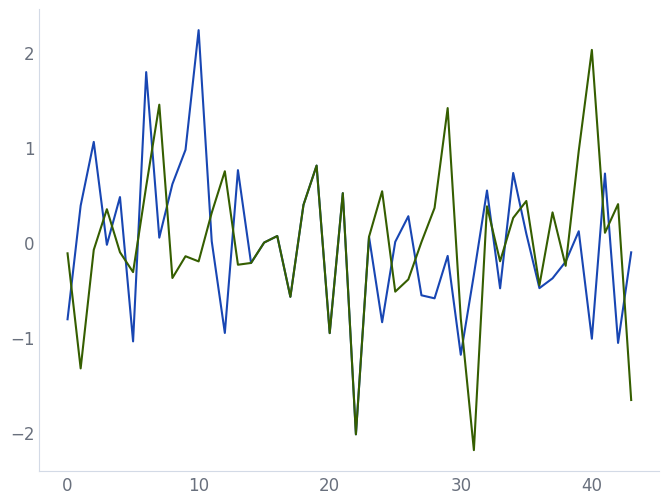

In [461]:
plt.plot(x1)
plt.plot(x2)

In [427]:
out_cue.filter(keep='0')

{0: 2x0} [0.05584282 1.1635344 ]

In [409]:
out_e3nn.filter(lmax=0)

2x0e [-1.0438296  2.909592 ]

In [410]:
x1 - x2

Array([ 1.0996723 , -1.7460575 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.334709  , -1.9533051 ,
       -1.6259837 , -0.5536774 ,  0.4211443 , -1.2848783 ,  1.2876683 ,
        0.36333185, -1.6061617 , -4.520699  ,  2.7018907 ,  2.5972848 ,
       -0.8696607 , -3.091805  ,  0.6522469 ,  1.4793229 , -0.73642385,
        0.48770332,  1.9590476 ,  0.8514452 , -0.53323555,  0.65232205,
        0.5140223 ,  1.5257372 , -1.3272561 ,  0.34033298,  1.3079576 ,
        0.7510832 ,  1.0292989 ,  1.6237904 ,  0.05171067,  2.80904   ],      dtype=float32)

In [411]:
x2[2:8].reshape(2, 3)

Array([[-0.9932875 ,  0.69651127,  0.2585017 ],
       [ 1.6614106 , -1.0278797 , -2.1800723 ]], dtype=float32)

In [412]:
tp.instructions

[Instruction(i=0,0,1, mode=uvu, has_weight=True, path_weight=1.7320508075688772, weight_std=1.0, mul=2,1,2, path_shape=(2, 1), num_elements=1),
 Instruction(i=0,1,0, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=2,1,2, path_shape=(2, 1), num_elements=1),
 Instruction(i=0,1,2, mode=uvu, has_weight=True, path_weight=1.7320508075688772, weight_std=1.0, mul=2,1,2, path_shape=(2, 1), num_elements=1),
 Instruction(i=0,1,4, mode=uvu, has_weight=True, path_weight=2.23606797749979, weight_std=1.0, mul=2,1,2, path_shape=(2, 1), num_elements=1),
 Instruction(i=0,2,3, mode=uvu, has_weight=True, path_weight=1.7320508075688772, weight_std=1.0, mul=2,1,2, path_shape=(2, 1), num_elements=1),
 Instruction(i=0,2,5, mode=uvu, has_weight=True, path_weight=2.23606797749979, weight_std=1.0, mul=2,1,2, path_shape=(2, 1), num_elements=1)]

In [413]:
e.d.paths

[op0[0]*op1[0]*op2[0]*op3[1]*c c.shape=(3, 1, 3) c.nnz=3,
 op0[1]*op1[0]*op2[1]*op3[0]*c c.shape=(3, 3, 1) c.nnz=3,
 op0[2]*op1[0]*op2[1]*op3[2]*c c.shape=(3, 3, 3) c.nnz=6,
 op0[3]*op1[0]*op2[1]*op3[4]*c c.shape=(3, 3, 5) c.nnz=11,
 op0[4]*op1[0]*op2[2]*op3[3]*c c.shape=(3, 5, 3) c.nnz=11,
 op0[5]*op1[0]*op2[2]*op3[5]*c c.shape=(3, 5, 5) c.nnz=16]

In [414]:
e.d.permute_segments(3, (5, 4, 3, 2, 1, 0)).paths

[op0[0]*op1[0]*op2[0]*op3[4]*c c.shape=(3, 1, 3) c.nnz=3,
 op0[1]*op1[0]*op2[1]*op3[5]*c c.shape=(3, 3, 1) c.nnz=3,
 op0[2]*op1[0]*op2[1]*op3[3]*c c.shape=(3, 3, 3) c.nnz=6,
 op0[3]*op1[0]*op2[1]*op3[1]*c c.shape=(3, 3, 5) c.nnz=11,
 op0[4]*op1[0]*op2[2]*op3[2]*c c.shape=(3, 5, 3) c.nnz=11,
 op0[5]*op1[0]*op2[2]*op3[0]*c c.shape=(3, 5, 5) c.nnz=16]

In [400]:
e.d.paths[4].coefficients[0, 0]

array([0.        , 0.        , 0.31622777])

In [245]:
tp.instructions

[Instruction(i=0,0,0, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=128,1,128, path_shape=(128, 1), num_elements=1),
 Instruction(i=0,1,3, mode=uvu, has_weight=True, path_weight=1.7320508075688772, weight_std=1.0, mul=128,1,128, path_shape=(128, 1), num_elements=1),
 Instruction(i=0,2,9, mode=uvu, has_weight=True, path_weight=2.23606797749979, weight_std=1.0, mul=128,1,128, path_shape=(128, 1), num_elements=1),
 Instruction(i=1,0,4, mode=uvu, has_weight=True, path_weight=1.7320508075688772, weight_std=1.0, mul=64,1,64, path_shape=(64, 1), num_elements=1),
 Instruction(i=1,1,1, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=64,1,64, path_shape=(64, 1), num_elements=1),
 Instruction(i=1,1,5, mode=uvu, has_weight=True, path_weight=1.7320508075688772, weight_std=1.0, mul=64,1,64, path_shape=(64, 1), num_elements=1),
 Instruction(i=1,1,10, mode=uvu, has_weight=True, path_weight=2.23606797749979, weight_std=1.0, mul=64,1,64, path_shape=(64, 1), num_elements

In [246]:
out_cue.irreps

128x0+64x0+32x0+128x1+64x1+64x1+64x1+32x1+32x1+128x2+64x2+64x2+32x2+32x2+32x2

In [248]:
e3nn.tensor_product('128x0e + 64x1e + 32x2e', '0e + 1e + 2e', regroup_output=False)

128x0e+64x0e+32x0e+128x1e+64x1e+64x1e+64x1e+32x1e+32x1e+128x2e+64x2e+64x2e+32x2e+32x2e+32x2e+64x3e+32x3e+32x3e+32x4e

In [222]:
diff = out_cue.array - out_e3nn.array
jnp.abs(diff).mean()

Array(0.79989266, dtype=float32)

In [223]:
jnp.abs(jnp.sort(x1) - jnp.sort(x2)).max()

Array(0.6176491, dtype=float32)

In [225]:
a_2e = out_cue.filter(keep=0)
b_2e = out_e3nn.filter(keep='0e')

jnp.mean(jnp.abs(jnp.sort(a_2e.array[::5]) - jnp.sort(b_2e.array[::5])))

Array(0.15157627, dtype=float32)

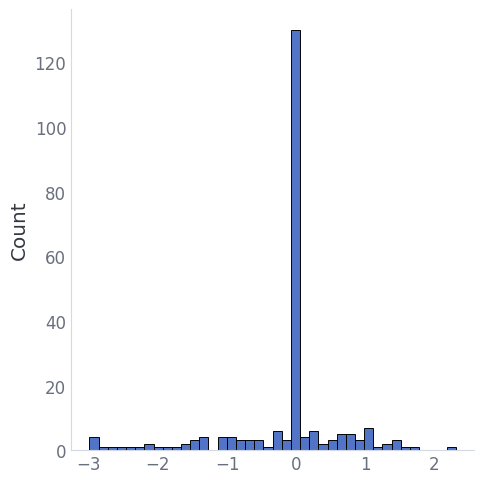

In [226]:
sns.displot(a_2e.array - b_2e.array, bins=40)

In [237]:
a_2e.array.round(2)[::16]

Array([ 0.16      ,  0.59      ,  1.35      , -0.7       , -0.38      ,
        0.22      ,  0.35999998, -0.48999998,  2.04      ,  0.        ,
        0.78999996, -0.63      , -0.38      , -2.03      ], dtype=float32)

In [238]:
b_2e.array.round(2)[::16]

Array([ 0.16      ,  0.59      ,  1.35      , -0.7       , -0.38      ,
        0.22      ,  0.35999998, -0.48999998,  1.22      , -0.5       ,
       -0.13      , -1.9799999 ,  0.35999998, -1.7199999 ], dtype=float32)

In [247]:
tp.instructions

[Instruction(i=0,0,0, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=128,1,128, path_shape=(128, 1), num_elements=1),
 Instruction(i=0,1,3, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=128,1,128, path_shape=(128, 1), num_elements=1),
 Instruction(i=0,2,9, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=128,1,128, path_shape=(128, 1), num_elements=1),
 Instruction(i=1,0,4, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=64,1,64, path_shape=(64, 1), num_elements=1),
 Instruction(i=1,1,1, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=64,1,64, path_shape=(64, 1), num_elements=1),
 Instruction(i=1,1,5, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=64,1,64, path_shape=(64, 1), num_elements=1),
 Instruction(i=1,1,10, mode=uvu, has_weight=True, path_weight=1.0, weight_std=1.0, mul=64,1,64, path_shape=(64, 1), num_elements=1),
 Instruction(i=1,2,6, mode=uvu, has_weight=True, path_weight=1.0, 

In [255]:
e.d.sort_paths((1, 2)).paths

[op0[0]*op1[0]*op2[0]*op3[0]*[[[1.]]],
 op0[3]*op1[0]*op2[1]*op3[3]*c c.shape=(1, 3, 3) c.nnz=3,
 op0[9]*op1[0]*op2[2]*op3[9]*c c.shape=(1, 5, 5) c.nnz=5,
 op0[4]*op1[1]*op2[0]*op3[4]*c c.shape=(3, 1, 3) c.nnz=3,
 op0[1]*op1[1]*op2[1]*op3[1]*c c.shape=(3, 3, 1) c.nnz=3,
 op0[5]*op1[1]*op2[1]*op3[5]*c c.shape=(3, 3, 3) c.nnz=6,
 op0[10]*op1[1]*op2[1]*op3[10]*c c.shape=(3, 3, 5) c.nnz=11,
 op0[6]*op1[1]*op2[2]*op3[6]*c c.shape=(3, 5, 3) c.nnz=11,
 op0[11]*op1[1]*op2[2]*op3[11]*c c.shape=(3, 5, 5) c.nnz=16,
 op0[12]*op1[2]*op2[0]*op3[12]*c c.shape=(5, 1, 5) c.nnz=5,
 op0[7]*op1[2]*op2[1]*op3[7]*c c.shape=(5, 3, 3) c.nnz=11,
 op0[13]*op1[2]*op2[1]*op3[13]*c c.shape=(5, 3, 5) c.nnz=16,
 op0[2]*op1[2]*op2[2]*op3[2]*c c.shape=(5, 5, 1) c.nnz=5,
 op0[8]*op1[2]*op2[2]*op3[8]*c c.shape=(5, 5, 3) c.nnz=16,
 op0[14]*op1[2]*op2[2]*op3[14]*c c.shape=(5, 5, 5) c.nnz=25]

In [116]:
jnp.sort(x1)

Array([-6.0003786, -5.043804 , -4.8613753, ...,  4.0026145,  4.367615 ,
        4.904835 ], dtype=float32)

In [ ]:
jnp.sort(x2)

Array([-6.000378 , -4.8613753, -3.8610375, ...,  4.0026145,  4.3676147,
        4.9048347], dtype=float32)